In [1]:
import keras
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras import layers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

IMG_SIZE = 256
BATCH_SIZE = 32

Using TensorFlow backend


In [2]:
random_seed = 27 # Must be same for train and validation
validation_split = 0.3
data_path = '../images'

ds_train = tf.keras.utils.image_dataset_from_directory(
directory = data_path,
batch_size = BATCH_SIZE,
validation_split = validation_split,
subset = 'training',
seed = random_seed)

ds_test = tf.keras.utils.image_dataset_from_directory(
directory = data_path,
batch_size = BATCH_SIZE,
validation_split = validation_split,
subset = 'validation',
seed = random_seed)

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 760 files belonging to 2 classes.
Using 532 files for training.
Found 760 files belonging to 2 classes.
Using 228 files for validation.


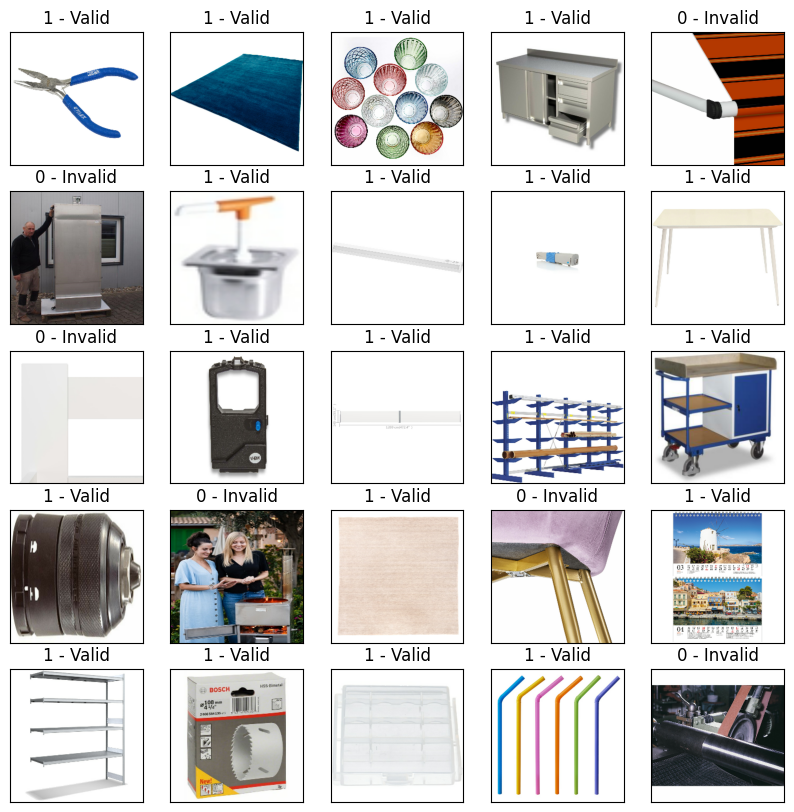

In [3]:
iterator = iter(ds_train)
images, labels = next(iterator)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].numpy().astype(int))
    plt.title('1 - Valid' if labels[i] == 1 else '0 - Invalid')
plt.show()

In [4]:
def build_model(learning_rate=0.0005, dropout_rate=0.2):
    model = models.Sequential()
    
    data_preprocessing = keras.Sequential([
        keras_cv.layers.Resizing(IMG_SIZE, IMG_SIZE),
        keras_cv.layers.Grayscale(output_channels=1),
        layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    ])

    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.RandomZoom(0.1),
    ])
    
    model.add(data_preprocessing)
    model.add(data_augmentation)

    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [5]:
model = build_model()

epochs = 49;

model_checkpoint = ModelCheckpoint(filepath='best_model.keras', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='min', verbose=1)

history = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[model_checkpoint])

Epoch 1/49
16/17 [===========================>..] - ETA: 0s - loss: 0.8344 - accuracy: 0.5520
Epoch 1: val_accuracy improved from inf to 0.31140, saving model to best_model.keras
17/17 [==============================] - 4s 139ms/step - loss: 0.8314 - accuracy: 0.5338 - val_loss: 0.7641 - val_accuracy: 0.3114
Epoch 2/49
17/17 [==============================] - ETA: 0s - loss: 0.8604 - accuracy: 0.2293
Epoch 2: val_accuracy did not improve from 0.31140
17/17 [==============================] - 1s 51ms/step - loss: 0.8604 - accuracy: 0.2293 - val_loss: 1.0148 - val_accuracy: 0.3114
Epoch 3/49
17/17 [==============================] - ETA: 0s - loss: 0.9229 - accuracy: 0.4774
Epoch 3: val_accuracy did not improve from 0.31140
17/17 [==============================] - 1s 52ms/step - loss: 0.9229 - accuracy: 0.4774 - val_loss: 1.3779 - val_accuracy: 0.6798
Epoch 4/49
17/17 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.6598
Epoch 4: val_accuracy did not improve from 0.3

8/8 - 0s - loss: 0.5937 - accuracy: 0.8509 - 123ms/epoch - 15ms/step


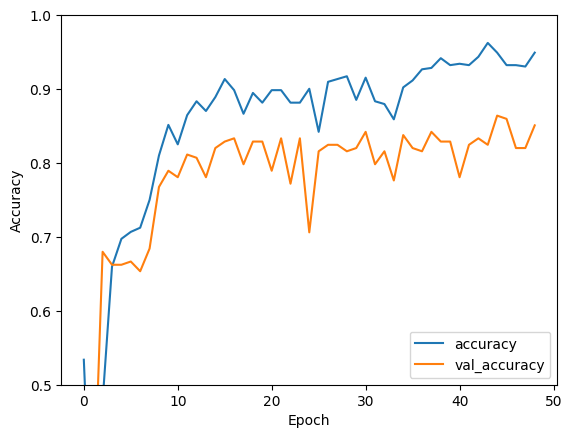

In [6]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)

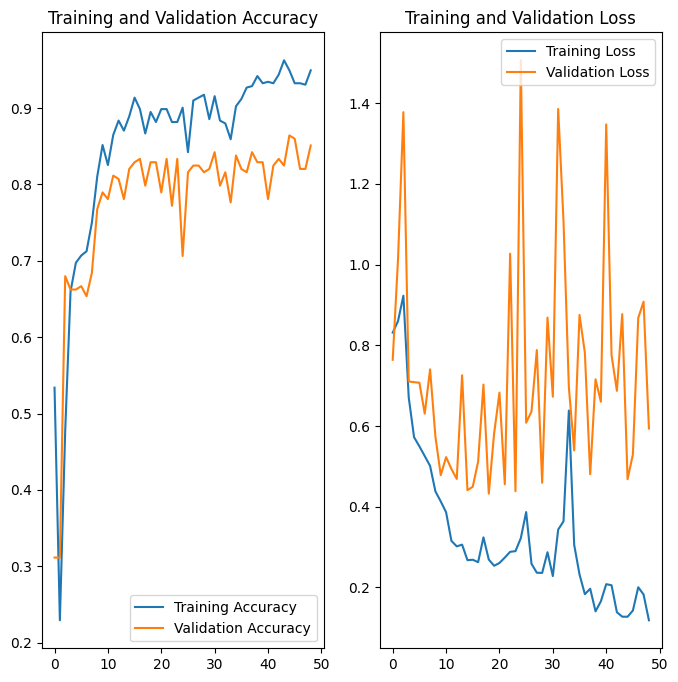

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
target_names = ['Invalid', 'Valid']

predictions = model.predict(ds_test)
pred_labels = np.where(predictions > 0, 1, 0)

real_labels = np.concatenate([labels.numpy() for _, labels in ds_test])

cm = tf.math.confusion_matrix(labels=real_labels, predictions=pred_labels)

8/8 [==============================] - 0s 16ms/step


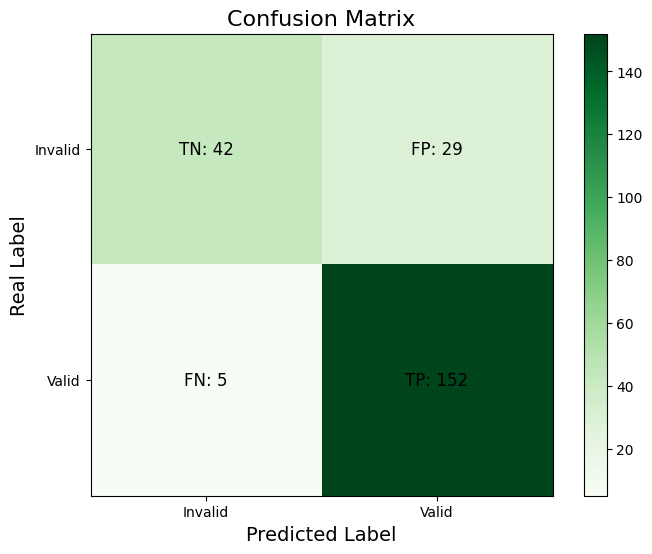

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Greens)
plt.title('Confusion Matrix', fontsize=16)
plt.colorbar()

classes = ['Invalid', 'Valid']
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)

text_labels = ['TN', 'FP', 'FN', 'TP']

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f"{text_labels[i*len(classes)+j]}: {cm[i, j]}", ha='center', va='center', fontsize=12)

plt.ylabel('Real Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.show()

In [10]:
test_image = "https://media.adeo.com/marketplace/LMES/83431706/1834868.jpeg"
test_image_path = tf.keras.utils.get_file('Test Image 8', origin=test_image)

img = tf.keras.utils.load_img(
    test_image_path, target_size=(IMG_SIZE, IMG_SIZE)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
predicted_class = 1 if predictions[0][0] > 0.5 else 0
confidence = 100 * np.abs(predictions[0][0])

print(
    "This image most likely belongs to {}. Confidence {:.2f}"
    .format(classes[predicted_class], confidence)
)

1/1 [==============================] - 0s 102ms/step
This image most likely belongs to Invalid. Confidence 888.97
